In [1]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyorbital

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install setuptools

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 32.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install /home/iiitd/Downloads/sat_track/pyEstimation

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



ERROR: Invalid requirement: '/home/iiitd/Downloads/sat_track/pyEstimation': Expected package name at the start of dependency specifier
    /home/iiitd/Downloads/sat_track/pyEstimation
    ^


In [6]:
pip install Basemap

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
  Using cached basemap-1.4.1-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached matplotlib-3.8.4-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached pyproj-3.6.1-cp312-cp312-win_amd64.whl.metadata (31 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached basemap-1.4.1-cp312-cp312-win_amd64.whl (507 kB)
Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
Using cached matplotlib-3.8.4-cp312-cp312-win_amd64.whl (7.7 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
Using cached packaging-23.2-py3-none-any.whl (53 kB)
Using cached pyproj-3.6.1-cp312-cp312-win_amd64.whl (6.1 MB)
  Attempting uninstall: packaging
    Found existing installat

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Parth\\AppData\\Roaming\\Python\\Python312\\site-packages\\numpy\\_typing\\_add_docstring.py'
Check the permissions.



In [5]:
pip install poliastro

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('Users\Parth\Desktop\sat_track-20250411T094516Z-001')
# print(sys.path)
import numpy as np
import pandas as pd
from orbit_module import access_tle, get_orbit
#from ssapy.orbit_sampling import orbit_sampler, orbit2df
from utilities import prop_param_calculator, GS_observation, get_ephemeris, plot_setting
from datetime import datetime
from astropy.time import Time
import pickle
import numba
from astropy.constants import R_earth
from astropy import units as u
from matplotlib import pyplot as plt
from scipy.stats import poisson
from scipy.special import erf
from scipy.constants import pi
from scipy.stats import expon
from pyEstimation import ExtendedKalmanFilter, state, models
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from astropy.time import Time
plot_setting()
%load_ext autoreload
%autoreload 2

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Parth\AppData\Local\Temp\ipykernel_19948\1883376176.py:2: SyntaxWarning: invalid escape sequence '\P'
  sys.path.append('Users\Parth\Desktop\sat_track-20250411T094516Z-001')
C:\Users\Parth\AppData\Local\Temp\ipykernel_19948\1883376176.py:2: SyntaxWarning: invalid escape sequence '\P'
  sys.path.append('Users\Parth\Desktop\sat_track-20250411T094516Z-001')


ImportError: cannot import name 'time_range' from 'poliastro.util' (C:\Users\Parth\AppData\Roaming\Python\Python312\site-packages\poliastro\util.py)

### Simulation Time

In [ ]:
date_format = "%Y-%m-%d"
initial_date =datetime.strptime('2024-05-14', date_format)
init_time = Time(initial_date, format='datetime')
deltaT = 60*u.s # observation interval
total_time = 4*u.h # total observation time 
n_time_Sample, interval = prop_param_calculator(total_time.to(u.s).value, deltaT.value)

### Ground station generation

In [ ]:
NUMBER_OF_GROUND_STATIONS = 100
lat_list = np.linspace(-85, 85, np.sqrt(NUMBER_OF_GROUND_STATIONS).astype(int))
lon_list = np.linspace(-180, 180, np.sqrt(NUMBER_OF_GROUND_STATIONS).astype(int))
alt_list = np.zeros(NUMBER_OF_GROUND_STATIONS)
#alt_list = np.zeros(NUMBER_OF_GROUND_STATIONS)
lat_grid, lon_grid = np.meshgrid(lat_list, lon_list)
lat_array = lat_grid.flatten()
lon_array = lon_grid.flatten()
gs_list = [{'lat': lat_array[i]*u.deg, 'lon': lon_array[i]*u.deg, 'alt': alt_list[i]*u.m} for i in range(NUMBER_OF_GROUND_STATIONS)]

In [ ]:
#sat_id = 'STARLINK-1007'
sat_id = 'NAVSTAR 73'
#sat_id = 'IRNSS-1A'
TLE = access_tle()
orbit = get_orbit(sat_id, TLE)
delt = init_time - orbit.epoch
orb_latest = orbit.propagate(delt)
ephemeris = get_ephemeris(orb_latest, n_time_Sample, interval)
epochs = ephemeris.epochs

In [ ]:
#@jit
def generate_observation(ephemeris, gs_list, mask_angle):
    epochs = ephemeris.epochs
    r_sat_eci = ephemeris.sample(epochs)
    for i in range(len(gs_list)):
        observation = GS_observation(gs_list[i], r_sat_eci, epochs, mask_angle)
        el = observation.elevation
        el = el[~np.isnan(el)]
        if el.size == 0:
            continue
        else:
            break
    gs_index = i
    observation.range = observation.range*r_sat_eci.xyz.unit
    observation.azimuth = observation.azimuth*u.deg
    observation.elevation = observation.elevation*u.deg
    return observation, gs_index

### Observation

In [ ]:
mask_angle = 10
observation, gs_index = generate_observation(ephemeris, gs_list, mask_angle)
print('Ground station location')
print(f'Latiude: {gs_list[gs_index]["lat"]:0.2f}')
print(f'Longitude: {gs_list[gs_index]["lon"]:0.2f}')
print(f'Altitude: {gs_list[gs_index]["alt"]:0.2f}')

Ground station location
Latiude: -85.00 deg
Longitude: -180.00 deg
Altitude: 0.00 m


### Add noise

In [ ]:
sigma_range = 0.1 # km
sigma_azimuth = 0.001 # degree
sigma_elevation = 0.001 # degree
RAE_obs = observation.add_noise(sigma_range, sigma_azimuth, sigma_elevation)

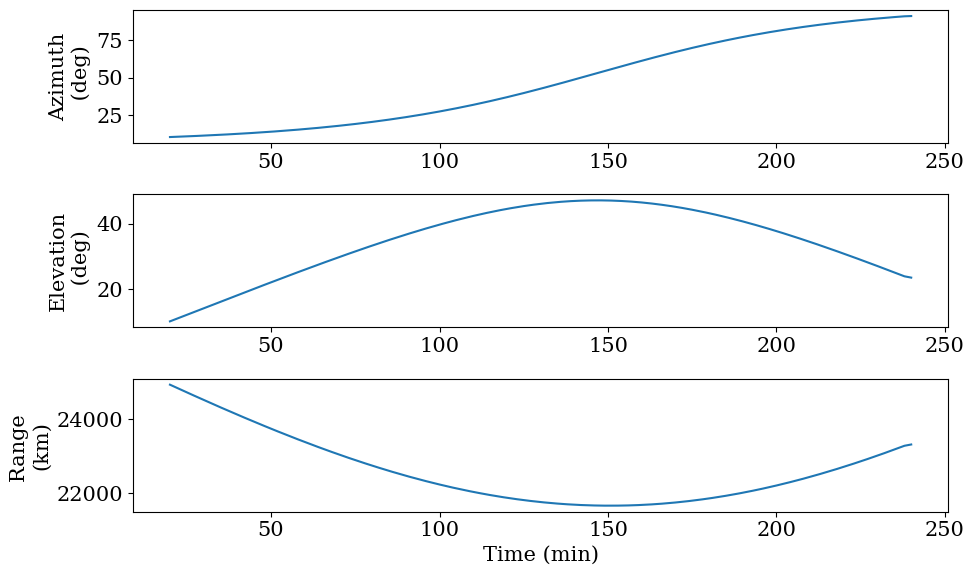

In [ ]:
obs_fig, obs_ax = plt.subplots(3, 1, figsize=(10, 6))
elapsed_time = [dt.hour*60 + dt.minute for dt in epochs.datetime]
obs_ax[0].plot(elapsed_time, RAE_obs.azimuth)
obs_ax[0].set_ylabel('Azimuth\n (deg)')

obs_ax[1].plot(elapsed_time, RAE_obs.elevation)
obs_ax[1].set_ylabel('Elevation\n (deg)')

obs_ax[2].plot(elapsed_time, RAE_obs.range)
obs_ax[2].set_ylabel('Range \n(km)')
obs_ax[2].set_xlabel('Time (min)')
obs_fig.tight_layout()

### Models

In [ ]:
def satdynamics(t, x):
    from astropy.constants import GM_earth
    mu = GM_earth.to(u.km**3/u.s**2).value
    r = x[0:3]
    v = x[3:6]
    r_dot = v
    r_ddot = -mu*r/np.linalg.norm(r)**3
    return np.concatenate([r_dot, r_ddot])

class sat_jacobian:
    def __init__(self, delta_t):
        self.delta_t = delta_t
    def __call__(self, x):
        from astropy.constants import GM_earth
        from scipy.linalg import expm
        mu = GM_earth.to(u.km**3/u.s**2).value
        r = x[0:3]
        v = x[3:6]
        A = np.zeros((6,6))
        A[0:3, 3:6] = np.eye(3)
        A[3:6, 0:3] = -mu*np.eye(3)/np.linalg.norm(r)**3
        return expm(A*self.delta_t)

class observation_model:
    def __init__(self, location, epoch):
        self.location = location
        self.epoch = epoch
    def __call__(self, x):
        from astropy.coordinates import SkyCoord
        from astropy.coordinates import AltAz, EarthLocation, GCRS, ITRS
        gs_location = EarthLocation(lat = self.location['lat'], lon = self.location['lon'], height = self.location['alt'])
        r_gcrs =SkyCoord(x[0]*u.km, x[1]*u.km, x[2]*u.km, representation_type='cartesian').cartesian
        sat_pos_gcrs = GCRS(r_gcrs, obstime=self.epoch)
        sat_pos_itrs = sat_pos_gcrs.transform_to(ITRS(obstime=self.epoch))
        obs = sat_pos_itrs.transform_to(AltAz(obstime = self.epoch, location = gs_location))
        range = obs.distance.value
        azimuth = obs.az.value
        elevation = obs.alt.value
        self.observation = np.array([range, np.deg2rad(azimuth), np.deg2rad(elevation)])
        return self.observation


class observation_jacobian:
    def __init__(self, location, epoch):
        self.location = location
        self.epoch = epoch
        self.obs = observation_model(location, epoch)
    def __call__(self, x):
        from astropy.coordinates import AltAz, EarthLocation
        from utilities import gcrs_to_itrs, itrs_to_enu
        rae = self.obs(x)
        gs_location = EarthLocation(lat = self.location['lat'], lon = self.location['lon'], height = self.location['alt'])
        obs_AltAz = AltAz(distance = rae[0]*u.km, az = rae[1]*u.rad, alt = rae[2]*u.rad, location = gs_location, obstime = self.epoch)
        sat_enu = obs_AltAz.cartesian.xyz.value
        R_FI = gcrs_to_itrs(self.epoch) # ECI to ECEF
        R_TF = itrs_to_enu(self.location) # ECEF to Topocentric
        delrho_delr = sat_enu/np.linalg.norm(sat_enu)@R_TF@R_FI
        delAz_delr = np.array([sat_enu[1]/(sat_enu[0]**2 + sat_enu[1]**2),\
                                -sat_enu[0]/(sat_enu[0]**2 + sat_enu[1]**2), \
                                    0])@R_TF@R_FI
        delEl_delr = np.array([-sat_enu[2]*sat_enu[0]/(np.linalg.norm(sat_enu[:2])*np.linalg.norm(sat_enu)**2), \
                              - sat_enu[2]*sat_enu[1]/(np.linalg.norm(sat_enu[:2])*np.linalg.norm(sat_enu)**2), \
                                    np.linalg.norm(sat_enu[:2])/np.linalg.norm(sat_enu)**2])@R_TF@R_FI
        delh_delr = np.array([delrho_delr, delAz_delr, delEl_delr])
        return np.concatenate((delh_delr, np.zeros((3,3))), axis=1)

def residue_process(z, z_priori):
    res = z - z_priori
    res[1] = np.deg2rad(res[1])
    res[2] = np.deg2rad(res[2])
    # if res[1] > np.pi:
    #     res[1] = res[1] - 2*np.pi
    # if res[1] < 0:
    #     res[1] = res[1] + 2*np.pi
    return res

def model_update(kf_object, location, next_epoch, deltaT):
    kf_object.model.dynamics = satdynamics
    Fjacobian = sat_jacobian(deltaT.value)
    kf_object.model.Phi = Fjacobian
    obs_model = observation_model(location, next_epoch)
    kf_object.model.h = obs_model
    obs_jacobian = observation_jacobian(location, next_epoch)
    kf_object.model.H = obs_jacobian
    #kf_object.model.residue_process = residue_process
    return #kf_object

def discrete_Q_update(kf_object, var_noise):
    Phi = kf_object.model.Phi(kf_object.state_priori.x)
    D = np.zeros((6,3))
    D[3:,:] = np.eye(3)
    Q = Phi@D@D.T@Phi.T*var_noise
    kf_object.Q = Q
    return kf_object

def dwna(sigma_a, dim, deltaT):
    """_summary_
    Discrete white noise acceleration model
    Args:
        sigma_a (_type_): acceleration standard deviation
        dim (_type_): dimension of the state vector
        deltaT (_type_): time interval in seconds

    Returns:
        _type_: _description_
    """
    Q = np.empty((dim, dim))
    dim_half = dim//2
    Q[:dim_half,:dim_half] = 1/4*deltaT.value**4*np.eye(dim_half)
    Q[dim_half:,dim_half:] = 1/2*deltaT.value**3*np.eye(dim_half)
    Q[dim_half:,:dim_half] = 1/2*deltaT.value**3*np.eye(dim_half)
    Q[:dim_half,dim_half:] = deltaT.value**2*np.eye(dim_half)
    Q = Q*sigma_a**2
    return Q

### Kalman Filter for tracking
#### Initialisation

In [ ]:
Z = np.array([RAE_obs.range.value, np.deg2rad(RAE_obs.azimuth.value), np.deg2rad(RAE_obs.elevation.value)]).T
start_index = np.argwhere(~np.isnan(Z[:,0]))[0].item()
end_index = np.argwhere(~np.isnan(Z[:,0]))[-1].item()
state0 = state()
state0.x = np.concatenate([ephemeris.rv(epochs[start_index])[0].value, ephemeris.rv(epochs[start_index])[1].value]) \
    + np.array([1, 1, 1, 0.01, 0.01, 0.01])
#state0.P = np.diag([0.5, 0.5, 0.5, 1e-2, 1e-2, 1e-2])
state0.P = np.diag([10, 10, 10, 0.5, 0.5, 0.5])
state0.t = 0

x_est_ekf = np.zeros((len(epochs[start_index:end_index]), state0.x.size))
std_est_ekf = np.zeros((len(epochs[start_index:end_index]), state0.x.size))
res = np.zeros((len(epochs[start_index:end_index]), Z.shape[1]))

x_est_ekf[0,:] = state0.x
std_est_ekf[0,:] = np.sqrt(np.diag(state0.P))

sigma_a = 1e-6
dim = len(state0.x)
Q = dwna(sigma_a, dim, deltaT)
Q_fudge = np.eye(dim)
Q_fudge[:3,:3] = 1e-4*np.eye(3)
#Q = Q + Q_fudge
# Q[3:,3:] = 1e-6*np.eye(3)
range_noise_Scale = 1
angle_noise_Scale = 1
sigma_r = sigma_range*range_noise_Scale
sigma_az = np.deg2rad(sigma_azimuth)*angle_noise_Scale
sigma_el = np.deg2rad(sigma_elevation)*angle_noise_Scale
R = np.diag([sigma_r**2, sigma_az**2, sigma_el**2])
satmodels = models()
print(f'Start: {start_index}| End: {end_index}')
print(len(Z))
print(Q)

Start: 20| End: 239
240
[[3.24e-06 0.00e+00 0.00e+00 3.60e-09 0.00e+00 0.00e+00]
 [0.00e+00 3.24e-06 0.00e+00 0.00e+00 3.60e-09 0.00e+00]
 [0.00e+00 0.00e+00 3.24e-06 0.00e+00 0.00e+00 3.60e-09]
 [1.08e-07 0.00e+00 0.00e+00 1.08e-07 0.00e+00 0.00e+00]
 [0.00e+00 1.08e-07 0.00e+00 0.00e+00 1.08e-07 0.00e+00]
 [0.00e+00 0.00e+00 1.08e-07 0.00e+00 0.00e+00 1.08e-07]]


In [ ]:
ekf = ExtendedKalmanFilter(satmodels, Q, R, state0, deltaT.value)
for i in range(0,len(epochs[start_index:end_index])-1):
    next_epoch = epochs[start_index + i + 1]
    model_update(ekf, gs_list[gs_index], next_epoch, deltaT)
    #ekf = discrete_Q_update(ekf, sigma_a**2)
    ekf.prediction()
    ekf.correction(Z[start_index + i + 1,:])
    x_est_ekf[i+1,:] = ekf.state_post.x
    std_est_ekf[i+1,:] = np.sqrt(np.diag(ekf.state_post.P))
    res[i+1,:] = ekf.state_post.res

Text(0.5, 0, 'Time (s)')

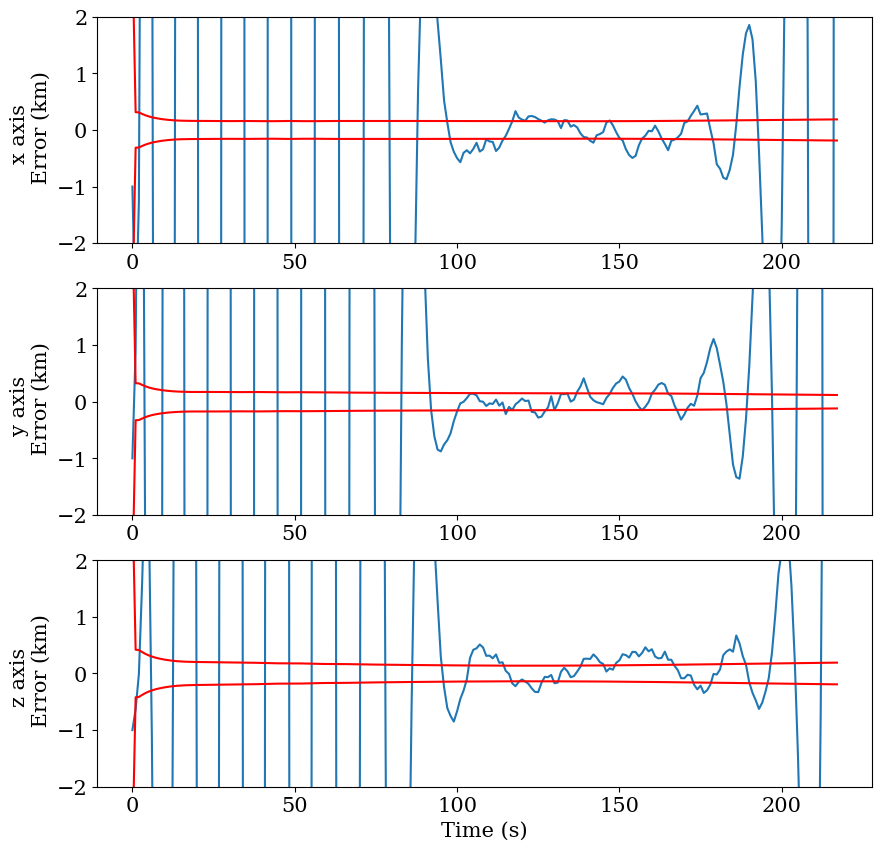

In [ ]:
ref_eci = np.concatenate((ephemeris.rv(ephemeris.epochs[start_index:end_index])[0].value,\
                           ephemeris.rv(ephemeris.epochs[start_index:end_index])[1].value), axis = 1)
error = ref_eci - x_est_ekf
end_point = -1
fig_error, ax_error = plt.subplots(3,1, figsize = (10,10))
ax_list = ['x', 'y', 'z']
for i in range(3):
    ax_error[i].plot(error[:end_point, i])
    ax_error[i].plot(std_est_ekf[:end_point, i], 'r')
    ax_error[i].plot(-std_est_ekf[:end_point, i], 'r')
    ax_error[i].set_ylim([-2, 2])
    ax_error[i].set_ylabel(f'{ax_list[i]} axis \n Error (km)')
ax_error[2].set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

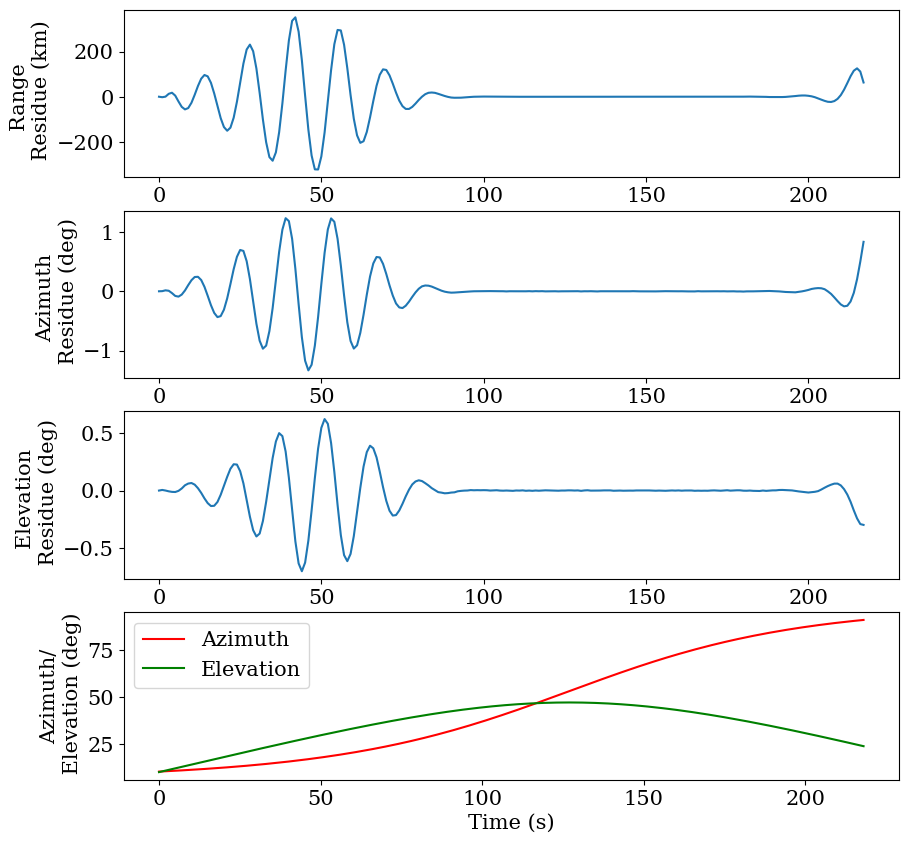

In [ ]:
fig, ax = plt.subplots(4,1, figsize = (10,10))

ax[0].plot(res[:end_point,0])
ax[0].set_ylabel('Range \n Residue (km)')

ax[1].plot(np.rad2deg(res[:end_point,1]))
ax[1].set_ylabel('Azimuth \n Residue (deg)')

ax[2].plot(np.rad2deg(res[:end_point,2]))
ax[2].set_ylabel('Elevation \n Residue (deg)')

ax[3].plot(RAE_obs.azimuth[start_index:end_index], 'r', label = 'Azimuth')
ax[3].plot(RAE_obs.elevation[start_index:end_index], 'g', label = 'Elevation')
ax[3].legend()
ax[3].set_ylabel('Azimuth/\n Elevation (deg)')
ax[3].set_xlabel('Time (s)')

In [ ]:
print(f'Peak: {np.argmin(res[:,1])}')
print(f'value in deg: {np.rad2deg(res[np.argmin(res[:,1]),1])}')
print(f'value in rad: {res[np.argmin(res[:,1]),1]}')

Peak: 46
value in deg: -1.3306996872174883
value in rad: -0.02322509089720387


## Propagation error

In [ ]:
ref_eci = np.concatenate((ephemeris.rv(epochs[start_index:end_index])[0].value,\
                           ephemeris.rv(epochs[start_index:end_index])[1].value), axis = 1)
from scipy.integrate import solve_ivp
t_ = np.linspace(0, total_time.to(u.s).value, len(epochs))
x_propagated = solve_ivp(satdynamics, [t_[start_index], t_[end_index]], state0.x, t_eval = t_[start_index:end_index], method = 'DOP853').y.T
print(x_propagated.shape)

(219, 6)


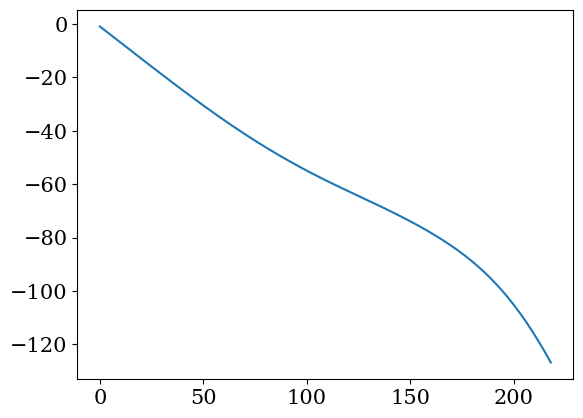

In [ ]:
plt.plot(ref_eci[:,0] - x_propagated[:,0])

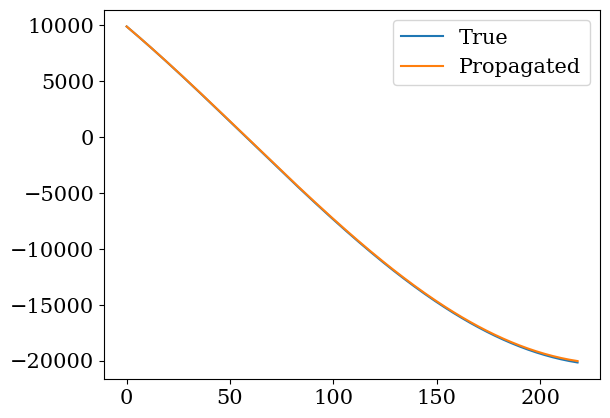

In [ ]:
plt.plot(ref_eci[:,0], label = 'True')
plt.plot(x_propagated[:,0], label = 'Propagated')
plt.legend()